In [1]:
# Library imports.
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../')
plt.style.use('seaborn')

# Repository imports.
import DataGenerator
import LocalNetBase
import network
import train

## Visualize random halfspace data

Note: For the clearest separation, set dim = 2 (we only plot the first two dimensions here).

points: (1000, 3) float64
labels: (1000,) bool


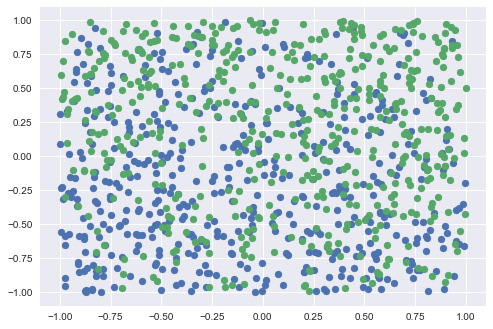

In [2]:
dim = 3
n = 1000
points, labels = DataGenerator.random_halfspace_data(dim, n)
print('points:', points.shape, points.dtype)
print('labels:', labels.shape, labels.dtype)
ones = labels
zeros = np.invert(labels)
plt.scatter(points[:, 0][ones], points[:, 1][ones])
plt.scatter(points[:, 0][zeros], points[:, 1][zeros])
plt.show()

## Visualize random ReLU data

Note: Sometimes, all points end up having the same label.

points: (1000, 2) float32
labels: (1000,) int64


..\DataGenerator.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out2 = F.softmax(torch.matmul(out1, w1))


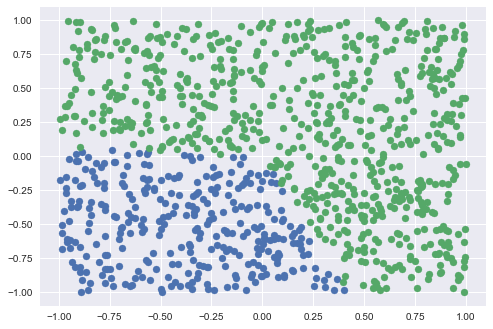

In [3]:
dim = 2
n = 1000
k = 10
points, labels = DataGenerator.layer_relu_data(dim, n, k)
print('points:', points.shape, points.dtype)
print('labels:', labels.shape, labels.dtype)
ones = labels.astype(np.bool)
zeros = np.invert(ones)
# ax.scatter(points[:, 0][ones], points[:, 1][ones], labels[ones])
# ax.scatter(points[:, 0][zeros], points[:, 1][zeros], labels[zeros])
plt.scatter(points[:, 0][ones], points[:, 1][ones])
plt.scatter(points[:, 0][zeros], points[:, 1][zeros])
plt.show()

## Visualize MNIST

In [4]:
import torchvision
import torchvision.datasets
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
print('mnist_train:', len(mnist_train))
print('mnist_test:', len(mnist_test))

mnist_train: 60000
mnist_test: 10000


In [5]:
X = np.array([np.array(pair[0]) for pair in mnist_train]) / 255.0
y = np.array([pair[1] for pair in mnist_train])
X_test = np.array([np.array(pair[0]) for pair in mnist_test]) / 255.0
y_test = np.array([pair[1] for pair in mnist_test])
print('X:', X.shape)
print('y:', y.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
mnist_X, mnist_y, mnist_X_test, mnist_y_test = X, y, X_test, y_test

X: (60000, 28, 28)
y: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


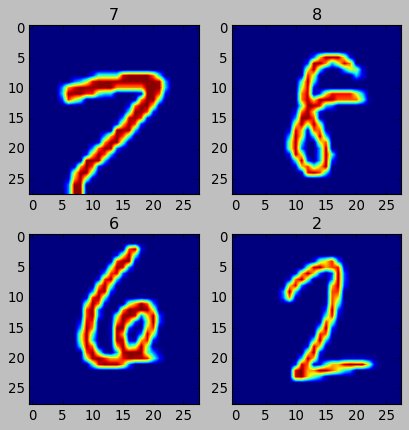

In [6]:
plt.style.use('classic')
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].imshow(X[123])
ax[0, 0].set_title(y[123])
ax[0, 1].imshow(X[456])
ax[0, 1].set_title(y[456])
ax[1, 0].imshow(X_test[123])
ax[1, 0].set_title(y_test[123])
ax[1, 1].imshow(X_test[456])
ax[1, 1].set_title(y_test[456])
plt.show()
plt.style.use('seaborn')

## Instantiate and inspect RNN

This is based on the README. Notes:

* The "rounds" parameter seems to be defined as T-1, so rounds=1 <=> T=2!

* The word "graph" in the code refers to the recurrent portion of the RNN, i.e. the randomly, sparsely connected part, excluding input and output neurons.

* I'm not sure as to what the best options are for which scenario, feel free to experiment with this.

In [7]:
options = LocalNetBase.Options(
    use_input_rule = False,    # Use an input rule to update input layer weights.
    use_output_rule = False,   # Use an output rule to update input layer weights.
    gd_output_rule = False,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
    use_graph_rule = True,
    gd_graph_rule = True,
    gd_input = False,          # gd directly on input layer weights.
    gd_output = False,         # gd directly on output layer weights.
    additive_rule = True)      # If false, uses multiplicative updates.

scheme = LocalNetBase.UpdateScheme(
    cross_entropy_loss = True,      # By default, uses cross entropy loss.
    mse_loss = False,
    update_misclassified_only = True,    # By default only update weights when we misclassify.
    update_all_edges = False)       # For output rule, update all edges, or only edge to correct and predicted label.

local_net = network.LocalNet(n = 4,  # number of input features (= dimension)
                             m = 2,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)
    
print('local_net input_rule:')
print(local_net.input_rule)  # 2^T, randomly initialized
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # 2^T x 2^T, randomly initialized
print('local_net output_rule:')
print(local_net.get_output_rule())  # 2^T x 2, all zero

local_net input_rule:
tensor([ 2.5787, -1.4635, -0.3242, -0.5793])
local_net rnn_rule:
tensor([[-0.8823,  0.6909, -1.3780, -0.4092],
        [ 0.7818, -1.3907, -0.5344, -0.2083],
        [ 0.9710, -1.7398,  2.3639,  0.6091],
        [ 0.0755,  0.0316,  0.0222, -0.4361]])
local_net output_rule:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


## Meta-learn rules using gradient descent on halfspace

  0%|                  | 0/20 [00:00<?, ?it/s]

Start meta-learning over outer (rule) epochs...


  5%|▌         | 1/20 [00:02<00:45,  2.38s/it]

Acc of class 0 : 0.7212
Acc of class 1 : 0.5852
Train accuracy: 0.6530
Acc of class 0 : 0.7420
Acc of class 1 : 0.5500
Test accuracy: 0.6460
Current loss: 0.7474
Mean loss so far: 0.7474


 10%|█         | 2/20 [00:04<00:43,  2.39s/it]

Acc of class 0 : 0.8536
Acc of class 1 : 0.6431
Train accuracy: 0.7480
Acc of class 0 : 0.8580
Acc of class 1 : 0.6840
Test accuracy: 0.7710
Current loss: 0.6918
Mean loss so far: 0.7196


 15%|█▌        | 3/20 [00:07<00:40,  2.35s/it]

Acc of class 0 : 0.7342
Acc of class 1 : 0.5503
Train accuracy: 0.6420
Acc of class 0 : 0.7280
Acc of class 1 : 0.5260
Test accuracy: 0.6270
Current loss: 0.6278
Mean loss so far: 0.6890


 20%|██        | 4/20 [00:09<00:37,  2.32s/it]

Acc of class 0 : 0.9448
Acc of class 1 : 0.3290
Train accuracy: 0.6360
Acc of class 0 : 0.9600
Acc of class 1 : 0.3540
Test accuracy: 0.6570
Current loss: 0.5920
Mean loss so far: 0.6648


 25%|██▌       | 5/20 [00:11<00:34,  2.29s/it]

Acc of class 0 : 0.9649
Acc of class 1 : 0.6171
Train accuracy: 0.7905
Acc of class 0 : 0.9900
Acc of class 1 : 0.5940
Test accuracy: 0.7920
Current loss: 0.4996
Mean loss so far: 0.6317


 30%|███       | 6/20 [00:13<00:31,  2.26s/it]

Acc of class 0 : 0.7904
Acc of class 1 : 0.6650
Train accuracy: 0.7275
Acc of class 0 : 0.8080
Acc of class 1 : 0.6280
Test accuracy: 0.7180
Current loss: 0.5170
Mean loss so far: 0.6126


 35%|███▌      | 7/20 [00:15<00:28,  2.17s/it]

Acc of class 0 : 0.9559
Acc of class 1 : 0.8076
Train accuracy: 0.8815
Acc of class 0 : 0.9580
Acc of class 1 : 0.8180
Test accuracy: 0.8880
Current loss: 0.4871
Mean loss so far: 0.5947


 40%|████      | 8/20 [00:17<00:25,  2.16s/it]

Acc of class 0 : 0.9759
Acc of class 1 : 0.6510
Train accuracy: 0.8130
Acc of class 0 : 0.9880
Acc of class 1 : 0.6600
Test accuracy: 0.8240
Current loss: 0.4974
Mean loss so far: 0.5825


 45%|████▌     | 9/20 [00:19<00:23,  2.12s/it]

Acc of class 0 : 0.9639
Acc of class 1 : 0.7218
Train accuracy: 0.8425
Acc of class 0 : 0.9780
Acc of class 1 : 0.7240
Test accuracy: 0.8510
Current loss: 0.4792
Mean loss so far: 0.5710


 50%|████▌    | 10/20 [00:21<00:20,  2.09s/it]

Acc of class 0 : 0.9930
Acc of class 1 : 0.5174
Train accuracy: 0.7545
Acc of class 0 : 0.9940
Acc of class 1 : 0.4920
Test accuracy: 0.7430
Current loss: 0.4721
Mean loss so far: 0.5611


 55%|████▉    | 11/20 [00:23<00:18,  2.07s/it]

Acc of class 0 : 0.8897
Acc of class 1 : 0.7198
Train accuracy: 0.8045
Acc of class 0 : 0.9080
Acc of class 1 : 0.7060
Test accuracy: 0.8070
Current loss: 0.4703
Mean loss so far: 0.5529


 60%|█████▍   | 12/20 [00:25<00:16,  2.04s/it]

Acc of class 0 : 0.9208
Acc of class 1 : 0.6500
Train accuracy: 0.7850
Acc of class 0 : 0.9660
Acc of class 1 : 0.6400
Test accuracy: 0.8030
Current loss: 0.4765
Mean loss so far: 0.5465


 65%|█████▊   | 13/20 [00:27<00:14,  2.04s/it]

Acc of class 0 : 0.9589
Acc of class 1 : 0.7478
Train accuracy: 0.8530
Acc of class 0 : 0.9720
Acc of class 1 : 0.7460
Test accuracy: 0.8590
Current loss: 0.4808
Mean loss so far: 0.5415


 70%|██████▎  | 14/20 [00:29<00:12,  2.05s/it]

Acc of class 0 : 0.9428
Acc of class 1 : 0.8933
Train accuracy: 0.9180
Acc of class 0 : 0.9740
Acc of class 1 : 0.9140
Test accuracy: 0.9440
Current loss: 0.4702
Mean loss so far: 0.5364


 75%|██████▊  | 15/20 [00:32<00:10,  2.09s/it]

Acc of class 0 : 0.9549
Acc of class 1 : 0.6361
Train accuracy: 0.7950
Acc of class 0 : 0.9660
Acc of class 1 : 0.6320
Test accuracy: 0.7990
Current loss: 0.4747
Mean loss so far: 0.5323


 80%|███████▏ | 16/20 [00:34<00:08,  2.09s/it]

Acc of class 0 : 0.9438
Acc of class 1 : 0.8435
Train accuracy: 0.8935
Acc of class 0 : 0.9640
Acc of class 1 : 0.8740
Test accuracy: 0.9190
Current loss: 0.4590
Mean loss so far: 0.5277


 85%|███████▋ | 17/20 [00:36<00:06,  2.09s/it]

Acc of class 0 : 0.9268
Acc of class 1 : 0.8674
Train accuracy: 0.8970
Acc of class 0 : 0.9440
Acc of class 1 : 0.8740
Test accuracy: 0.9090
Current loss: 0.4572
Mean loss so far: 0.5235


 90%|████████ | 18/20 [00:38<00:04,  2.09s/it]

Acc of class 0 : 0.8275
Acc of class 1 : 0.9531
Train accuracy: 0.8905
Acc of class 0 : 0.8480
Acc of class 1 : 0.9520
Test accuracy: 0.9000
Current loss: 0.4452
Mean loss so far: 0.5192


 95%|████████▌| 19/20 [00:40<00:02,  2.08s/it]

Acc of class 0 : 0.9769
Acc of class 1 : 0.4995
Train accuracy: 0.7375
Acc of class 0 : 0.9880
Acc of class 1 : 0.4880
Test accuracy: 0.7380
Current loss: 0.4402
Mean loss so far: 0.5150


100%|█████████| 20/20 [00:42<00:00,  2.13s/it]

Acc of class 0 : 0.7864
Acc of class 1 : 0.9601
Train accuracy: 0.8735
Acc of class 0 : 0.7900
Acc of class 1 : 0.9700
Test accuracy: 0.8800
Current loss: 0.4531
Mean loss so far: 0.5119


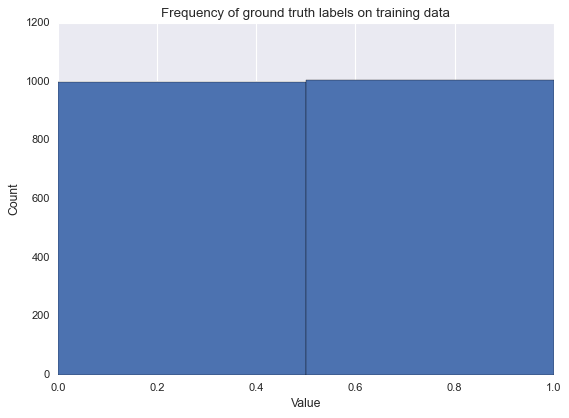

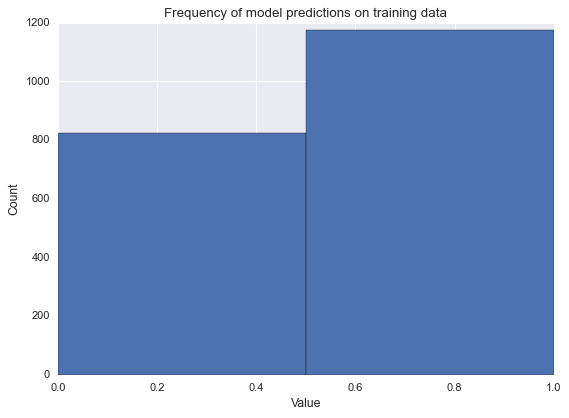

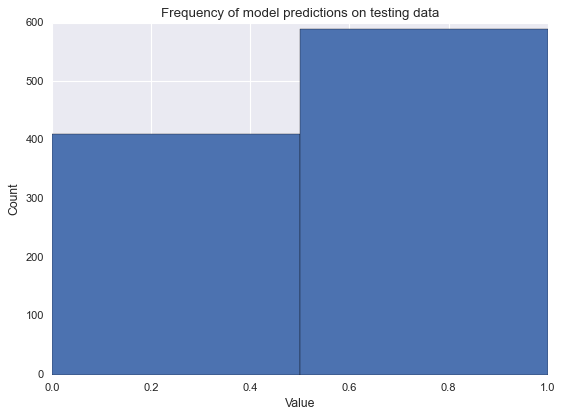

Last loss: 0.4531
Last train accuracy: 0.8735
Last test accuracy: 0.8800


In [8]:
# Generate data.
dimension = 4
n = 1000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# Meta-learn rules.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.metalearn_rules(
    X,                      # Training inputs
    y,                      # Training labels
    local_net,              # The BrainNet
    num_rule_epochs = 20,   # Number of meta-learning epochs
    num_epochs = 2,         # Number of times to process a single batch
    batch_size = 100,       # Number of samples in a batch
    learn_rate = 1e-2,      # Learning rate
    X_test = X_test,
    y_test = y_test,
    verbose = True)

In [9]:
# Print essential stats (also done in the method itself).
print("Last loss: {0:.4f}".format(all_losses[-1]))
print("Last train accuracy: {0:.4f}".format(all_train_acc[-1]))
print("Last test accuracy: {0:.4f}".format(all_test_acc[-1]))

Last loss: 0.4531
Last train accuracy: 0.8735
Last test accuracy: 0.8800


all_losses: (20,)
all_train_acc: (20,)
all_test_acc: (20,)
sample_counts: (20,)


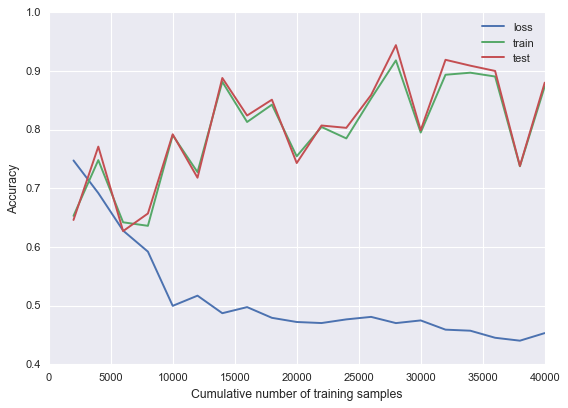

In [10]:
# Plot upstream training curves.
print('all_losses:', all_losses.shape)  # Equals number of outer epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts, all_losses, label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
# Print rules.
print('local_net input_rule:')
print(local_net.input_rule)  # Same as before (cannot be learned?).
print('local_net rnn_rule:')
print(local_net.get_rnn_rule())  # Learned.
print('local_net output_rule:')
print(local_net.get_output_rule())  # Same as before (we specified not to learn this).

local_net input_rule:
tensor([ 2.5787, -1.4635, -0.3242, -0.5793])
local_net rnn_rule:
tensor([[-0.5196,  0.4854, -0.4630,  0.2719],
        [ 0.6323,  0.1083,  0.0228,  0.8022],
        [ 1.4680, -0.3966,  0.2045, -0.0251],
        [ 0.6507,  0.4058, -0.5701, -0.6353]], dtype=torch.float64)
local_net output_rule:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


## Train with the already learned rules on a different halfspace

  0%|                | 0/2000 [00:00<?, ?it/s]

Acc of class 0 : 0.4626
Acc of class 1 : 0.6570
INITIAL train accuracy: 0.5635
Acc of class 0 : 0.4948
Acc of class 1 : 0.6673
INITIAL test accuracy: 0.5850
Epoch 1 / 10 ...


 28%|█▍   | 565/2000 [00:00<00:01, 735.13it/s]

Acc of class 0 : 0.9574
Acc of class 1 : 0.7428
Step 500 / 2000
Train accuracy: 0.8460
Acc of class 0 : 0.9518
Acc of class 1 : 0.7744
Test accuracy: 0.8590
Current loss: 0.4822
Mean loss so far: 0.2411


 54%|██▏ | 1072/2000 [00:01<00:01, 771.98it/s]

Acc of class 0 : 0.9262
Acc of class 1 : 0.8170
Step 1000 / 2000
Train accuracy: 0.8695
Acc of class 0 : 0.9140
Acc of class 1 : 0.8413
Test accuracy: 0.8760
Current loss: 0.4659
Mean loss so far: 0.3160


 82%|███▎| 1644/2000 [00:01<00:00, 909.34it/s]

Acc of class 0 : 0.9335
Acc of class 1 : 0.7254
Step 1500 / 2000
Train accuracy: 0.8255
Acc of class 0 : 0.9161
Acc of class 1 : 0.7763
Test accuracy: 0.8430
Current loss: 0.4273
Mean loss so far: 0.3438


  4%|▏     | 83/2000 [00:00<00:02, 829.12it/s]

Acc of class 0 : 1.0000
Acc of class 1 : 0.4008
Step 2000 / 2000
Train accuracy: 0.6890
Acc of class 0 : 0.9979
Acc of class 1 : 0.4436
Test accuracy: 0.7080
Current loss: 0.4990
Mean loss so far: 0.3749

Epoch 2 / 10 ...


 30%|█▍   | 599/2000 [00:00<00:01, 854.14it/s]

Acc of class 0 : 0.9813
Acc of class 1 : 0.8227
Step 500 / 2000
Train accuracy: 0.8990
Acc of class 0 : 0.9748
Acc of class 1 : 0.8547
Test accuracy: 0.9120
Current loss: 0.4406
Mean loss so far: 0.3858


 53%|██  | 1061/2000 [00:01<00:01, 854.67it/s]

Acc of class 0 : 0.9792
Acc of class 1 : 0.6503
Step 1000 / 2000
Train accuracy: 0.8085
Acc of class 0 : 0.9790
Acc of class 1 : 0.6711
Test accuracy: 0.8180
Current loss: 0.5017
Mean loss so far: 0.4024


 81%|███▏| 1618/2000 [00:01<00:00, 904.18it/s]

Acc of class 0 : 0.9605
Acc of class 1 : 0.6262
Step 1500 / 2000
Train accuracy: 0.7870
Acc of class 0 : 0.9581
Acc of class 1 : 0.6577
Test accuracy: 0.8010
Current loss: 0.4526
Mean loss so far: 0.4086


  5%|▎     | 95/2000 [00:00<00:02, 948.87it/s]

Acc of class 0 : 0.9823
Acc of class 1 : 0.5424
Step 2000 / 2000
Train accuracy: 0.7540
Acc of class 0 : 0.9895
Acc of class 1 : 0.5621
Test accuracy: 0.7660
Current loss: 0.4992
Mean loss so far: 0.4187

Epoch 3 / 10 ...


 30%|█▍   | 599/2000 [00:00<00:01, 859.26it/s]

Acc of class 0 : 0.9470
Acc of class 1 : 0.6069
Step 500 / 2000
Train accuracy: 0.7705
Acc of class 0 : 0.9245
Acc of class 1 : 0.6310
Test accuracy: 0.7710
Current loss: 0.4735
Mean loss so far: 0.4242


 57%|██▎ | 1146/2000 [00:01<00:01, 851.05it/s]

Acc of class 0 : 0.9709
Acc of class 1 : 0.8160
Step 1000 / 2000
Train accuracy: 0.8905
Acc of class 0 : 0.9623
Acc of class 1 : 0.8145
Test accuracy: 0.8850
Current loss: 0.4421
Mean loss so far: 0.4258


 79%|███▏| 1583/2000 [00:01<00:00, 808.88it/s]

Acc of class 0 : 0.8514
Acc of class 1 : 0.9104
Step 1500 / 2000
Train accuracy: 0.8820
Acc of class 0 : 0.8532
Acc of class 1 : 0.9197
Test accuracy: 0.8880
Current loss: 0.3917
Mean loss so far: 0.4230


  5%|▎     | 95/2000 [00:00<00:02, 939.63it/s]

Acc of class 0 : 0.9605
Acc of class 1 : 0.8006
Step 2000 / 2000
Train accuracy: 0.8775
Acc of class 0 : 0.9518
Acc of class 1 : 0.8088
Test accuracy: 0.8770
Current loss: 0.4101
Mean loss so far: 0.4220

Epoch 4 / 10 ...


 30%|█▍   | 591/2000 [00:00<00:01, 846.96it/s]

Acc of class 0 : 0.9886
Acc of class 1 : 0.5848
Step 500 / 2000
Train accuracy: 0.7790
Acc of class 0 : 0.9874
Acc of class 1 : 0.6214
Test accuracy: 0.7960
Current loss: 0.5085
Mean loss so far: 0.4282


 58%|██▎ | 1153/2000 [00:01<00:00, 927.36it/s]

Acc of class 0 : 0.9771
Acc of class 1 : 0.5453
Step 1000 / 2000
Train accuracy: 0.7530
Acc of class 0 : 0.9832
Acc of class 1 : 0.5717
Test accuracy: 0.7680
Current loss: 0.4995
Mean loss so far: 0.4329


 80%|███▏| 1605/2000 [00:01<00:00, 945.47it/s]

Acc of class 0 : 0.9823
Acc of class 1 : 0.6233
Step 1500 / 2000
Train accuracy: 0.7960
Acc of class 0 : 0.9665
Acc of class 1 : 0.6099
Test accuracy: 0.7800
Current loss: 0.4698
Mean loss so far: 0.4352


  5%|▎     | 96/2000 [00:00<00:01, 959.13it/s]

Acc of class 0 : 0.9688
Acc of class 1 : 0.5356
Step 2000 / 2000
Train accuracy: 0.7440
Acc of class 0 : 0.9665
Acc of class 1 : 0.5641
Test accuracy: 0.7560
Current loss: 0.4890
Mean loss so far: 0.4384

Epoch 5 / 10 ...


 32%|█▌   | 641/2000 [00:00<00:01, 864.52it/s]

Acc of class 0 : 0.8669
Acc of class 1 : 0.6686
Step 500 / 2000
Train accuracy: 0.7640
Acc of class 0 : 0.8386
Acc of class 1 : 0.6769
Test accuracy: 0.7540
Current loss: 0.5053
Mean loss so far: 0.4421


 56%|██▏ | 1112/2000 [00:01<00:00, 902.23it/s]

Acc of class 0 : 0.7848
Acc of class 1 : 0.8854
Step 1000 / 2000
Train accuracy: 0.8370
Acc of class 0 : 0.7673
Acc of class 1 : 0.9082
Test accuracy: 0.8410
Current loss: 0.4924
Mean loss so far: 0.4448


 81%|███▎| 1627/2000 [00:01<00:00, 809.66it/s]

Acc of class 0 : 0.7526
Acc of class 1 : 0.9451
Step 1500 / 2000
Train accuracy: 0.8525
Acc of class 0 : 0.7317
Acc of class 1 : 0.9388
Test accuracy: 0.8400
Current loss: 0.4418
Mean loss so far: 0.4446


  5%|▎    | 100/2000 [00:00<00:01, 999.09it/s]

Acc of class 0 : 0.7890
Acc of class 1 : 0.9615
Step 2000 / 2000
Train accuracy: 0.8785
Acc of class 0 : 0.7925
Acc of class 1 : 0.9637
Test accuracy: 0.8820
Current loss: 0.4138
Mean loss so far: 0.4431

Epoch 6 / 10 ...


 31%|█▌   | 620/2000 [00:00<00:01, 856.85it/s]

Acc of class 0 : 0.8659
Acc of class 1 : 0.6985
Step 500 / 2000
Train accuracy: 0.7790
Acc of class 0 : 0.8700
Acc of class 1 : 0.6941
Test accuracy: 0.7780
Current loss: 0.4869
Mean loss so far: 0.4451


 56%|██▏ | 1115/2000 [00:01<00:00, 986.23it/s]

Acc of class 0 : 0.8451
Acc of class 1 : 0.8776
Step 1000 / 2000
Train accuracy: 0.8620
Acc of class 0 : 0.8218
Acc of class 1 : 0.8967
Test accuracy: 0.8610
Current loss: 0.4585
Mean loss so far: 0.4457


 81%|███▏| 1616/2000 [00:01<00:00, 892.54it/s]

Acc of class 0 : 0.9116
Acc of class 1 : 0.7871
Step 1500 / 2000
Train accuracy: 0.8470
Acc of class 0 : 0.8889
Acc of class 1 : 0.8088
Test accuracy: 0.8470
Current loss: 0.4249
Mean loss so far: 0.4448


  5%|▎     | 93/2000 [00:00<00:02, 929.16it/s]

Acc of class 0 : 0.9740
Acc of class 1 : 0.5896
Step 2000 / 2000
Train accuracy: 0.7745
Acc of class 0 : 0.9602
Acc of class 1 : 0.5985
Test accuracy: 0.7710
Current loss: 0.4372
Mean loss so far: 0.4445

Epoch 7 / 10 ...


 32%|█▌   | 632/2000 [00:00<00:01, 867.35it/s]

Acc of class 0 : 0.8441
Acc of class 1 : 0.8285
Step 500 / 2000
Train accuracy: 0.8360
Acc of class 0 : 0.8302
Acc of class 1 : 0.8184
Test accuracy: 0.8240
Current loss: 0.4985
Mean loss so far: 0.4466


 55%|██▏ | 1106/2000 [00:01<00:01, 876.09it/s]

Acc of class 0 : 0.8940
Acc of class 1 : 0.7784
Step 1000 / 2000
Train accuracy: 0.8340
Acc of class 0 : 0.8868
Acc of class 1 : 0.7744
Test accuracy: 0.8280
Current loss: 0.4832
Mean loss so far: 0.4480


 78%|███▏| 1563/2000 [00:01<00:00, 884.81it/s]

Acc of class 0 : 0.9563
Acc of class 1 : 0.6859
Step 1500 / 2000
Train accuracy: 0.8160
Acc of class 0 : 0.9560
Acc of class 1 : 0.7189
Test accuracy: 0.8320
Current loss: 0.4746
Mean loss so far: 0.4489


  5%|▎     | 93/2000 [00:00<00:02, 929.15it/s]

Acc of class 0 : 0.9491
Acc of class 1 : 0.6936
Step 2000 / 2000
Train accuracy: 0.8165
Acc of class 0 : 0.9350
Acc of class 1 : 0.7170
Test accuracy: 0.8210
Current loss: 0.4451
Mean loss so far: 0.4488

Epoch 8 / 10 ...


 31%|█▌   | 629/2000 [00:00<00:01, 884.28it/s]

Acc of class 0 : 0.9657
Acc of class 1 : 0.7225
Step 500 / 2000
Train accuracy: 0.8395
Acc of class 0 : 0.9581
Acc of class 1 : 0.7476
Test accuracy: 0.8480
Current loss: 0.4853
Mean loss so far: 0.4500


 55%|██▏ | 1106/2000 [00:01<00:01, 880.22it/s]

Acc of class 0 : 0.9168
Acc of class 1 : 0.7669
Step 1000 / 2000
Train accuracy: 0.8390
Acc of class 0 : 0.9078
Acc of class 1 : 0.7610
Test accuracy: 0.8310
Current loss: 0.4586
Mean loss so far: 0.4503


 79%|███▏| 1586/2000 [00:01<00:00, 857.92it/s]

Acc of class 0 : 0.9075
Acc of class 1 : 0.8227
Step 1500 / 2000
Train accuracy: 0.8635
Acc of class 0 : 0.8931
Acc of class 1 : 0.8528
Test accuracy: 0.8720
Current loss: 0.4544
Mean loss so far: 0.4504


  5%|▎     | 98/2000 [00:00<00:01, 979.11it/s]

Acc of class 0 : 0.9595
Acc of class 1 : 0.8073
Step 2000 / 2000
Train accuracy: 0.8805
Acc of class 0 : 0.9518
Acc of class 1 : 0.8298
Test accuracy: 0.8880
Current loss: 0.4365
Mean loss so far: 0.4500

Epoch 9 / 10 ...


 33%|█▋   | 651/2000 [00:00<00:01, 927.81it/s]

Acc of class 0 : 0.8358
Acc of class 1 : 0.7736
Step 500 / 2000
Train accuracy: 0.8035
Acc of class 0 : 0.8365
Acc of class 1 : 0.7744
Test accuracy: 0.8040
Current loss: 0.5447
Mean loss so far: 0.4528


 53%|██  | 1054/2000 [00:01<00:01, 763.60it/s]

Acc of class 0 : 0.9033
Acc of class 1 : 0.7264
Step 1000 / 2000
Train accuracy: 0.8115
Acc of class 0 : 0.9057
Acc of class 1 : 0.7266
Test accuracy: 0.8120
Current loss: 0.4556
Mean loss so far: 0.4529


 82%|███▎| 1631/2000 [00:01<00:00, 790.73it/s]

Acc of class 0 : 0.9491
Acc of class 1 : 0.7428
Step 1500 / 2000
Train accuracy: 0.8420
Acc of class 0 : 0.9329
Acc of class 1 : 0.7495
Test accuracy: 0.8370
Current loss: 0.4507
Mean loss so far: 0.4528


  5%|▎     | 91/2000 [00:00<00:02, 909.17it/s]

Acc of class 0 : 0.9428
Acc of class 1 : 0.8160
Step 2000 / 2000
Train accuracy: 0.8770
Acc of class 0 : 0.9329
Acc of class 1 : 0.8050
Test accuracy: 0.8660
Current loss: 0.4345
Mean loss so far: 0.4523

Epoch 10 / 10 ...


 31%|█▌   | 623/2000 [00:00<00:01, 865.90it/s]

Acc of class 0 : 0.9428
Acc of class 1 : 0.7428
Step 500 / 2000
Train accuracy: 0.8390
Acc of class 0 : 0.9371
Acc of class 1 : 0.7782
Test accuracy: 0.8540
Current loss: 0.4765
Mean loss so far: 0.4529


 53%|██▏ | 1066/2000 [00:01<00:01, 807.01it/s]

Acc of class 0 : 0.9802
Acc of class 1 : 0.6532
Step 1000 / 2000
Train accuracy: 0.8105
Acc of class 0 : 0.9706
Acc of class 1 : 0.6711
Test accuracy: 0.8140
Current loss: 0.4892
Mean loss so far: 0.4539


 81%|███▎| 1628/2000 [00:01<00:00, 896.75it/s]

Acc of class 0 : 0.9730
Acc of class 1 : 0.6522
Step 1500 / 2000
Train accuracy: 0.8065
Acc of class 0 : 0.9769
Acc of class 1 : 0.6539
Test accuracy: 0.8080
Current loss: 0.4449
Mean loss so far: 0.4536


100%|████| 2000/2000 [00:02<00:00, 940.87it/s]


Acc of class 0 : 0.9241
Acc of class 1 : 0.7534
Step 2000 / 2000
Train accuracy: 0.8355
Acc of class 0 : 0.9099
Acc of class 1 : 0.7725
Test accuracy: 0.8380
Current loss: 0.4850
Mean loss so far: 0.4544



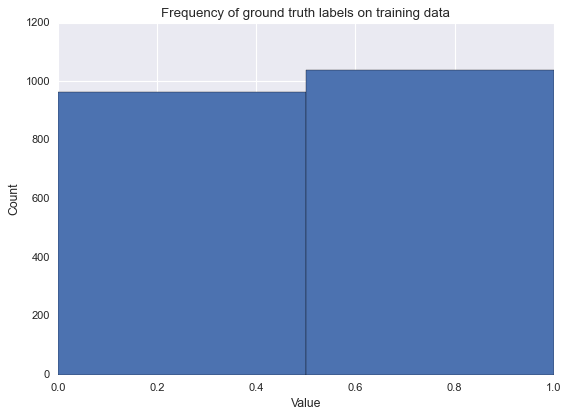

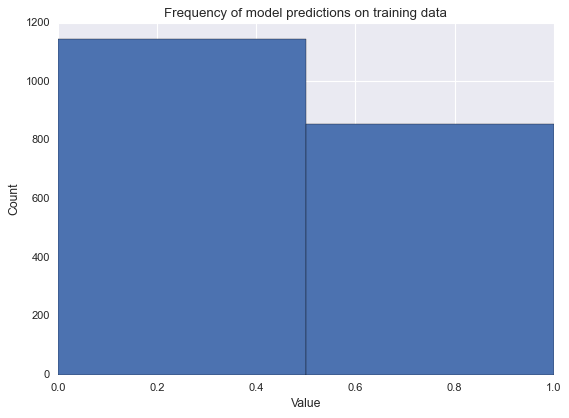

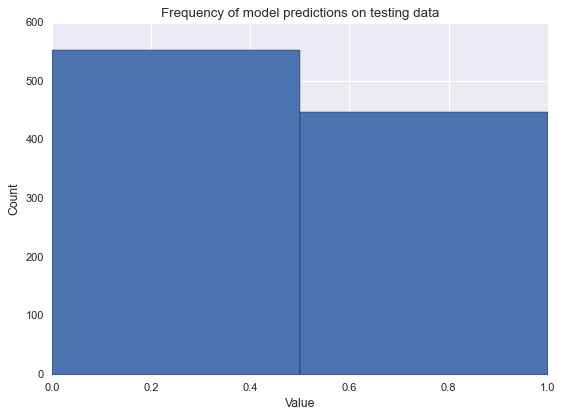

Last loss: 0.4850
Last train accuracy: 0.8355
Last test accuracy: 0.8380


In [12]:
# Generate data.
dimension = 4
n = 1000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# NOTE: This method trains only once over all examples, updating the stats every 500 steps.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.train_downstream(
    X,                      # Training inputs
    y,                      # Training Labels
    local_net,              # The BrainNet
    num_epochs = 10,
    batch_size = 1,
    vanilla = False,
    learn_rate = 1e-2,
    X_test = X_test,
    y_test = y_test,
    verbose = True)

In [13]:
# Print essential stats (also done in the method itself).
print("Last loss: {0:.4f}".format(all_losses[-1]))
print("Last train accuracy: {0:.4f}".format(all_train_acc[-1]))
print("Last test accuracy: {0:.4f}".format(all_test_acc[-1]))

Last loss: 0.4850
Last train accuracy: 0.8355
Last test accuracy: 0.8380


all_losses: (41,)
all_train_acc: (41,)
all_test_acc: (41,)
sample_counts: (41,)


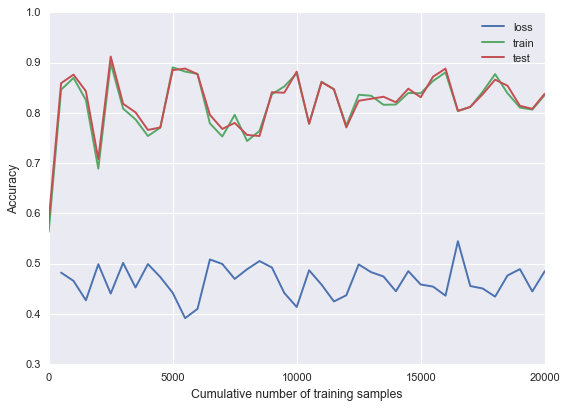

In [14]:
# Plot downstream training curves.
print('all_losses:', all_losses.shape)  # Equals 1 + number of sub-epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts[1:], all_losses[1:], label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Meta-learn rules on halfspace, train with fixed rules on MNIST

We create different upstream (halfspace) vs downstream (MNIST) network.

NOTE: the reason this doesn't work too well is because the actual procedures in the paper are a little more complicated, see **Appendix A.2**. I am using a halfspace dimension of 8 and MNIST is 28 x 28, and then the rules are copied across different networks.

Interestingly, even if the upstream accuracy is chance (50%), the downstream training still works sometimes...

In [15]:
options = LocalNetBase.Options(
    gd_input = True,          # GD directly on input layer weights.
    use_graph_rule = True,
    gd_graph_rule = True,
    use_output_rule = True,   # Use an output rule to update input layer weights.
    gd_output_rule = True,    # Learn an output rule, or use fixed one. If GD is used, set 'use_output_rule' to True as well.
    gd_output = False,        # GD directly on output layer weights.
    additive_rule = True)     # If false, uses multiplicative updates.

# ==== TODO: improve this to match paper ====

# Initialize new network.
dimension = 8
local_net = network.LocalNet(n = dimension,  # number of input features (= dimension)
                             m = 2,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)

# Generate halfspace data.
n = 4000
X, y = DataGenerator.random_halfspace_data(dim = dimension, n = 3*n)
X_test = X[:n]
y_test = y[:n]
X = X[n:]
y = y[n:]

# Learn rules.
(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.metalearn_rules(
    X, y, local_net, num_rule_epochs=20, num_epochs=2, batch_size=100, learn_rate=1e-2,
    X_test=X_test, y_test=y_test, verbose=False)

100%|█████████| 20/20 [02:41<00:00,  8.10s/it]

Last loss: 0.5307
Last train accuracy: 0.9661
Last test accuracy: 0.9653


all_losses: (20,)
all_train_acc: (20,)
all_test_acc: (20,)
sample_counts: (20,)


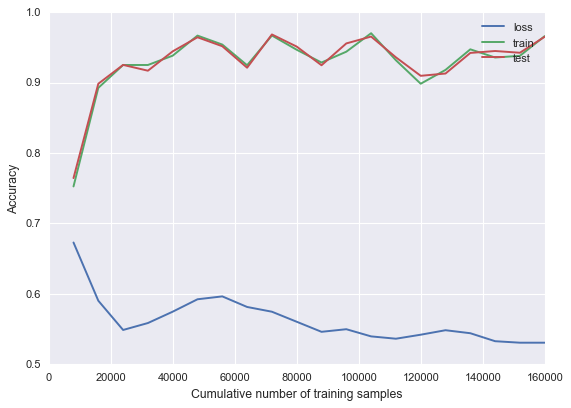

In [16]:
# Plot upstream training curves.
print('all_losses:', all_losses.shape)  # Equals number of outer epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts, all_losses, label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Transfer rules to new model
dimension = 28 * 28
mnist_net = network.LocalNet(n = dimension,  # number of input features (= dimension)
                             m = 10,  # number of possible labels
                             num_v = 100,  # number of nodes in graph
                             p = .5,  # probability that an edge exists in the graph
                             cap = 50,  # choose top 'cap' nodes which fire
                             rounds = 1,  # number of times the graph 'fires'
                             options = options, update_scheme = scheme)
# mnist_net.set_rnn_rule(local_net.get_rnn_rule())
# mnist_net.set_output_rule(local_net.get_output_rule())
mnist_net.rnn_rule = local_net.rnn_rule
mnist_net.output_rule = local_net.output_rule

# Recall MNIST data.
X, y, X_test, y_test = mnist_X, mnist_y, mnist_X_test, mnist_y_test
X = X.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

(all_losses, all_train_acc, all_test_acc, sample_counts, other_stats) = train.train_downstream(
    X, y, mnist_net, num_epochs=1, batch_size=1, vanilla=False, learn_rate=1e-2,
    X_test=X_test, y_test=y_test, verbose=False, stats_interval=3000)

INITIAL train accuracy: 0.1568
INITIAL test accuracy: 0.1588
Epoch 1 / 1 ...


100%|██| 60000/60000 [02:41<00:00, 371.58it/s]


Last loss: 1.9538
Last train accuracy: 0.4739
Last test accuracy: 0.4757


all_losses: (21,)
all_train_acc: (21,)
all_test_acc: (21,)
sample_counts: (21,)


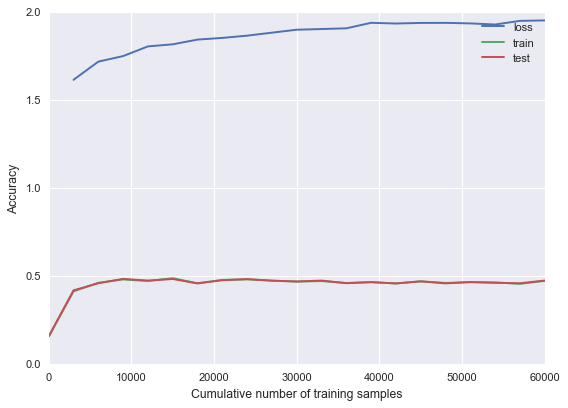

In [18]:
# Plot downstream training curves.
print('all_losses:', all_losses.shape)  # Equals 1 + number of sub-epochs.
print('all_train_acc:', all_train_acc.shape)
print('all_test_acc:', all_test_acc.shape)
print('sample_counts:', sample_counts.shape)
plt.figure()
plt.plot(sample_counts[1:], all_losses[1:], label='loss')
plt.plot(sample_counts, all_train_acc, label='train')
plt.plot(sample_counts, all_test_acc, label='test')
plt.xlabel('Cumulative number of training samples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()